In [10]:
#%%
print('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting')

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#%%
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting


In [11]:


def data_split(aa_array, encoded_mic):
    np.random.seed(seed)
    
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic.iloc[:,0],  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target

# def is_within_doubling_dilution(pred, target, target_min, target_max):
#     _ = np.arange(target_min-1, target_max+2, 1)
#     index = [i for i, x in enumerate(_) if x == target][0]
#     return (_[index-1] <= pred <= _[index+1])
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min.values-1, target_max.values+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# def is_within_doubling_dilution(pred, target, target_min, target_max):
#     # Convert Series to scalar if needed
#     if isinstance(pred, pd.Series):
#         pred = pred.iloc[0]  # or pred.item()
#     if isinstance(target, pd.Series):
#         target = target.iloc[0]  # or target.item()

#     _ = np.arange(target_min - 1, target_max + 2, 1)
#     # Now target is guaranteed to be a scalar
#     index = [i for i, x in enumerate(_) if x == target][0]
#     return (_[index - 1] <= pred <= _[index + 1])


In [12]:
def data_prep_(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']
    
    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']
    # print(variants.shape)
    # print(variants['sample_id'].unique().shape)

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    print('Getting all snp data', len(all_snp))
    for x in tqdm(overlap):
    # for x in tqdm(variants['sample_id'].unique()):
        if x in variants['sample_id'].tolist():
            aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        else:
            aa.append([0]*len(all_snp))
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(overlap)]#.iloc[:,14:27]
    # mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # print(mic_aa.shape)
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'
    # print(mic_aa.shape)

    return aa_array, mic_aa

In [13]:
drug = 'EMB'
df = pd.read_csv('../CRyPTIC_reuse_table_20231208.csv')

aa_array = np.load(f'./generated_data18122024/all_sample_snps_cryptic_{drug}.npy')
drs = np.load(f'./generated_data18122024/all_sample_drs_cryptic_{drug}.npy')

encoded_mic = pd.DataFrame(drs, columns=['EMB_MIC'])
mic_series = np.log2(encoded_mic)
mic_series += 1
# sample_ids = mic_aa['ENA_RUN']

mic_series_bi = encoded_mic['EMB_MIC'].apply(lambda x: 1 if x >= 8 else 0)
mic_series_all = pd.merge(mic_series, mic_series_bi, left_index=True, right_index=True)
# train_data, test_data,  test_target_y, test_target = data_split(aa_array, mic_series_all)
train_data, test_data, train_target, test_target = data_split(aa_array, mic_series_all)

target_min, target_max = mic_series.min(), mic_series.max()

In [14]:
train_ = np.load('./train.npy')

In [15]:
np.array_equal(train_data, train_)

True

### resampling

In [16]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler

# Assuming train_data is your feature array and train_target['EMB_MIC_x'] is your target array
X = train_data
y = train_target['EMB_MIC_x']

target_counts = {
    1.0: 3571,  # Keep the majority class as is
    2.0: 2661,  # Bring other classes closer
    3.0: 2000,
    4.0: 2000,
    0.0: 2000,
    5.0: 2000
}
# Initialize the RandomOverSampler
ros= RandomOverSampler(sampling_strategy=target_counts, random_state=42)
# ros = RandomOverSampler(random_state=42)

# Fit and resample the data
X_resampled, y_resampled = ros.fit_resample(X, y)

# Verify the new class distribution
from collections import Counter
print(Counter(y_resampled))
print(y_resampled.shape)
print(X_resampled.shape)

# train_mic_series_bi = y_resampled.apply(lambda x: 1 if x >= 4 else 0)
# train_target = pd.DataFrame({'EMB_MIC_x': y_resampled, 'EMB_MIC_y': train_mic_series_bi})
# train_data = X_resampled

Counter({1.0: 3571, 2.0: 2661, 3.0: 2000, 4.0: 2000, 0.0: 2000, 5.0: 2000})
(14232,)
(14232, 1710)


In [17]:
train_mic_series_bi = y_resampled.apply(lambda x: 1 if x >= 4 else 0)
train_target = pd.DataFrame({'EMB_MIC_x': y_resampled, 'EMB_MIC_y': train_mic_series_bi})
train_data = X_resampled

In [18]:
X_resampled.shape

(14232, 1710)

## cornloss weighting

In [10]:
train_target_counts = torch.from_numpy(train_target.values).flatten()
# train_target_counts = torch.tensor([0,1,2])


## xgb

#### 50k

In [8]:
# import numpy as np

# # Read the CSV file into a NumPy array
# aa_array = np.loadtxt('aa_array_50k.csv', delimiter=',').astype(float)  # Ensure all elements are floats
# # print(aa_array)


# # Read the text file line by line into a list and convert to floats
# with open('dr_target_50k.txt', 'r') as f:
#     mic_series = [float(line.strip()) for line in f]  # Convert each line to float

# # print(mic_series)
# mic_series_50k = mic_series

# aa_array_50k_pos = []
# mic_series_50k_pos = []
# for x, a in zip(mic_series_50k, aa_array):
#     if x == 1:
#         aa_array_50k_pos.append(a)
#         mic_series_50k_pos.append(x)
# aa_array_50k_pos = np.array(aa_array_50k_pos)
import numpy as np

drug = 'EMB'
df = pd.read_csv('../CRyPTIC_reuse_table_20231208.csv')

aa_array = np.load(f'./generated_data18122024/all_sample_snps_50k_{drug}_checks.npy')
drs = np.load(f'./generated_data18122024/all_sample_drs_50k_{drug}_checks.npy')
aa_array_50k_pos = aa_array
mic_series_50k_pos = drs

#### xgb training

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split


# train_data = np.column_stack((train_data, train_target['EMB_MIC_y'].values))
# test_data = np.column_stack((test_data, test_target['EMB_MIC_y'].values))
train_target_y = train_target['EMB_MIC_y'].values
test_target_y = test_target['EMB_MIC_y'].values

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_data, test_data, train_target_y, test_target_y
X_test = test_data
y_test = test_target['EMB_MIC_y'].values
X_train = np.concatenate((X_train, aa_array_50k_pos), axis=0)
y_train = np.concatenate((y_train, mic_series_50k_pos), axis=0)
# # Create the XGBoost model
# model_bi = xgb.XGBClassifier(    
#     max_depth=3,
#     learning_rate=0.9,
#     n_estimators=4,
#     # gamma=0.1,
#     # min_child_weight=24,
#     # subsample=0.2,
#     # colsample_bytree=1,
#     # reg_alpha=15, reg_lambda=15,
#     random_state=42 
#     )
# # Create the XGBoost model
# model_bi = xgb.XGBClassifier(colsample_bytree= 0.5, gamma= 0.1, learning_rate= 0.01, max_depth= 4, min_child_weight= 1, n_estimators= 200, subsample= 0.8,random_state=42)
model_bi = xgb.XGBClassifier(colsample_bytree= 0.5, gamma= 5, learning_rate= 0.3, max_depth= 7, min_child_weight= 1, n_estimators= 200, subsample= 0.8,random_state=42)

model_bi.fit(X_train, y_train)

# model_bi = pickle.load(open("xgb_bi_mix1.pkl", "rb"))
# model_bi = pickle.load(open("xgb_bi_mix.pkl", "rb"))
# model_bi = pickle.load(open("xgb_bi_50kbalanced.pkl", "rb"))

# Make predictions on the test set
y_pred = model_bi.predict(X_test)

# Evaluate the model_bi
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#testing
cutoff = 4
test_target_bi = y_test.astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = y_pred.astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()
print(confusion_matrix(test_target_bi, test_predictions_bi))
# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)  

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Accuracy: 0.8504837291116975
AUC: 0.8888201532804068
[[794 160]
 [ 10 173]]
Sensitivity: 0.9453551912568307
Specificity: 0.8322851153039832


In [19]:
test_target['EMB_MIC_y'] = test_predictions_bi

In [20]:
len(train_data)

14232

## Dataset

In [21]:
from torch.utils.data import Subset
from collections import Counter

N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)
#%%

def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )

# Julian's code - implement this, might be faster
class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_mic,
        target_res,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_res]
        self.mic_df = res_df[target_mic]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        index = int(index)
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            res = self.res_df.iloc[index]
            mic = self.mic_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            res = self.res_df.loc[index]
            mic = self.mic_df.loc[index]
            
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0), torch.tensor(mic).long().flatten().squeeze(), torch.tensor(res).long().flatten().squeeze()
    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, 'EMB_MIC_x','EMB_MIC_y', one_hot_dtype=torch.float, transform=False)
# train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

# test_data = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/snps_crypticTest_emb.npy')
# train_data = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/drs_crypticTest_emb.npy')
testing_dataset = Dataset(test_data, test_target, 'EMB_MIC_x','EMB_MIC_y',one_hot_dtype=torch.float, transform=False)

train_idx, validation_idx = train_test_split(np.arange(len(train_data)),
                                             test_size=0.1,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=train_target)

# Subset dataset for train and val
train_dataset = Subset(training_dataset, train_idx)
val_dataset = Subset(training_dataset, validation_idx)

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    # weights_inverse = 1 - frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn = get_weighted_masked_cross_entropy_loss(column_weight_maps['EMB_MIC_x'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss, optimizer, model):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f"#>> {appendix}, Epoch: {epoch}, LR: {lr}, fcDR: {fcdr}\n")
        f.write(f"Train_Loss= {train_loss}\n")
        f.write(f"Test_Loss= {test_loss}\n")
        f.write(f"lossGraph(Train_Loss, Test_Loss, '{appendix}-Epoch-{epoch}-LR-{lr}-fcDR-{fcdr}')\n")

    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

In [22]:

# test_data = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/snps_crypticTest_emb.npy')
# test_target = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/drs_crypticTest_emb.npy')
# testing_dataset = Dataset(test_data, test_target, 'EMB_MIC_x','EMB_MIC_y',one_hot_dtype=torch.float, transform=False)
# testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)


## Model

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    """
    A CNN architecture patterned after the reference figure:
    - Input
    - (conv1a) 1D Conv + ReLU [64 filters, kernel_size=5]
    - (conv1b) 1D Conv + ReLU [64 filters, kernel_size=12]
    - MaxPool1d(kernel_size=3, stride=1)
    - (conv2a) 1D Conv + ReLU [32 filters, kernel_size=3]
    - (conv2b) 1D Conv + ReLU [32 filters, kernel_size=3]
    - MaxPool1d(kernel_size=3, stride=1)
    - 2 × Fully-Connected (256 neurons) + ReLU
    - Output layer of size 13 (Sigmoid)
    """

    def __init__(self, 
                 in_channels=1, 
                 num_classes=13, 
                 additional_input_dim=1, 
                 return_logits=False):
        super().__init__()
        
        self.return_logits = return_logits

        # -------------------------
        # Convolution Block 1
        # -------------------------
        self.conv1a = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=5),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.conv1b = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=12),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=1)

        # -------------------------
        # Convolution Block 2
        # -------------------------
        self.conv2a = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.conv2b = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=3),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=1)

        # -------------------------
        # Fully Connected Layers
        # -------------------------
        # We will flatten after the second pool, so we do not know the
        # exact flattened size up front unless we do a test forward pass
        # or can analytically compute it. Here we assume we find it
        # dynamically in forward().
        #
        # Two fully-connected layers of 256 units each (with ReLU):
        self.fc1 = nn.Linear(1, 256)   # Placeholder; will be reset in forward()
        self.bn_fc1 = nn.BatchNorm1d(256)
        
        self.fc2 = nn.Linear(256, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)

        # -------------------------
        # Final Output Layer
        # -------------------------
        # If following the figure exactly, it's a sigmoid output of size 13.
        # If you want raw logits, set return_logits=True.
        # We also accept an additional input dimension (e.g. 1 scalar).
        # We'll incorporate that by adding to the flattened dimension
        # right before the FC layers.
        self.output_layer = (
            nn.Linear(256 + additional_input_dim, num_classes) 
            if return_logits else
            nn.Sequential(
                nn.Linear(256 + additional_input_dim, num_classes),
                nn.Sigmoid()  # or nn.Softmax(dim=1) if you prefer
            )
        )

        # Apply weight initialization
        self.apply(self.init_weights)

    def init_weights(self, m):
        """Kaiming initialization for Linear layers."""
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, additional_input):
        """
        x shape: [batch_size, in_channels, seq_len]
        additional_input shape: [batch_size] or [batch_size, additional_input_dim]
        """
        # Block 1
        x = self.conv1a(x)   # -> shape [B, 64, ...]
        x = self.conv1b(x)   # -> shape [B, 64, ...]
        x = self.pool1(x)    # -> shape [B, 64, ...]

        # Block 2
        x = self.conv2a(x)   # -> shape [B, 32, ...]
        x = self.conv2b(x)   # -> shape [B, 32, ...]
        x = self.pool2(x)    # -> shape [B, 32, ...]

        # Flatten
        x = x.view(x.size(0), -1)  # [B, features]

        # Lazy shape detection for FC layers
        # (We only know the exact shape after a forward pass.)
        if isinstance(self.fc1, nn.Linear) and self.fc1.in_features == 1:
            # Reinitialize fc1 in_features based on x
            in_features = x.shape[1]
            self.fc1 = nn.Linear(in_features, 256).to(x.device)
            nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
            self.bn_fc1 = nn.BatchNorm1d(256).to(x.device)

        # FC1
        x = self.fc1(x)            # -> shape [B, 256]
        x = self.bn_fc1(x)
        x = F.relu(x)

        # FC2
        x = self.fc2(x)            # -> shape [B, 256]
        x = self.bn_fc2(x)
        x = F.relu(x)

        # Incorporate additional input
        # If it's a single scalar per sample, make sure shape is [B, 1]
        if additional_input.dim() == 1:
            additional_input = additional_input.unsqueeze(1)

        # Concatenate along feature dimension
        x = torch.cat([x, additional_input], dim=1)  # shape [B, 256 + additional_input_dim]

        # Final output layer
        out = self.output_layer(x)
        return out


## Single run

 17%|█▋        | 50/300 [36:05<2:07:58, 30.71s/it] 

Epoch 50
Training loss: 0.3329530656337738
Validation loss: 0.33460938930511475


 33%|███▎      | 100/300 [59:18<1:26:01, 25.81s/it]

Epoch 100
Training loss: 0.3318028151988983
Validation loss: 0.3336421847343445


 50%|█████     | 150/300 [1:19:11<56:59, 22.79s/it]  

Epoch 150
Training loss: 0.33093103766441345
Validation loss: 0.33341822028160095


 67%|██████▋   | 200/300 [1:36:25<32:42, 19.62s/it]

Epoch 200
Training loss: 0.3300253748893738
Validation loss: 0.3331473171710968


 83%|████████▎ | 250/300 [1:52:18<16:47, 20.16s/it]

Epoch 250
Training loss: 0.3292286694049835
Validation loss: 0.33173686265945435


100%|██████████| 300/300 [2:06:43<00:00, 25.35s/it]

Epoch 300
Training loss: 0.3285309672355652
Validation loss: 0.330413818359375



/tmp/ipykernel_114876/2800227602.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)
Learning rate: 0.0001
Weight decay: 0.0001
Accuracy: 0.42480211081794195
Mae: 0.7255936675461742
F1 Score: 0.36825939028233856
conf_matrix: [[ 22  73  10   5   1   1]
 [ 55 291  38   3   9   1]
 [ 27 201  41   2  25   0]
 [  3  27  10   7  95   7]
 [  0   6   5   2  93  31]
 [  2   1   0   0  14  29]]
Doubling Dilution Accuracy: 0.8830255057167986
AUC: 0.8834329999656323
Sensitivity: 0.912568306010929
Specificity: 0.8542976939203354


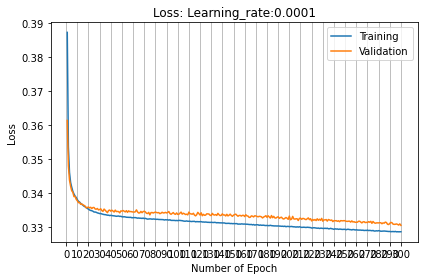

In [24]:
#input parameter
lr = 1e-4
epoch = 300
conv_dropout_rate=0.4
dense_dropout_rate=0.7
weight_decay=1e-4
######################################

model = CNNModel(
    in_channels=1,       # e.g. 1 channel, like a single feature dimension
    num_classes=16,      # matches the reference figure
    additional_input_dim=1,
    return_logits=False  # set True if you need raw logits
    ).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 64
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
criterion = weighted_cross_entropy_loss_fn
# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train, y_train_res in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        y_batch_res = y_train_res.to(device)
        
        x_batch = x_batch.float()
        pred = model(x_batch.float(),y_batch_res.float())

        # break
        # loss_train = loss_corn(pred, y_batch, 3, class_weights)
        # print(pred, y_batch)
        loss_train = criterion(pred,y_batch)
        # print(pred)
        # print(y_batch)
        # print(loss_train)
        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate
        # break
    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test, y_test_res in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            y_batch_res = y_test_res.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float(), y_batch_res.float())
            loss_test = criterion(pred,y_batch)
            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            # loss_test = loss_corn(pred, y_batch, 3, class_weights)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    if e%50 == 0:
        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
    
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%
# testing_dataset = Dataset(test_data, test_target, 'EMB_MIC_x','EMB_MIC_y',one_hot_dtype=torch.float, transform=False)
# testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)
# testing_dataset = Dataset(test_data, test_target, 'EMB_MIC_x','EMB_MIC_y',one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

# Ensure the model is on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []

with torch.no_grad():
    for x_test, y_test, y_test_res in testing_loader1:
        # Move input and target data to the correct device
        x_test = x_test.to(device).float()
        y_test = y_test.to(device).float()
        y_test_res = y_test_res.to(device).float()
        
        # Forward pass
        pred = model(x_test, y_test_res)
        
        # Append predictions and targets to lists
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
        
# Flatten the target list
target_list = np.array(target_list).flatten()

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score


def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min.values-1, target_max.values+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate AUC
cutoff = 4
test_target_bi = (target_list >= cutoff).astype(int)
test_predictions_bi = (np.array(pred_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

In [25]:

# Calculate AUC
cutoff = 4
test_target_bi = (target_list >= cutoff).astype(int)
test_predictions_bi = (np.array(pred_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

AUC: 0.8834329999656323
Sensitivity: 0.912568306010929
Specificity: 0.8542976939203354


In [26]:
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min.values-1, target_max.values+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

Doubling Dilution Accuracy: 0.8830255057167986


: 

In [19]:
PATH = './saved_model1115/emb_resFeed_working17122024.pth'
torch.save(model.state_dict(), PATH)


In [ ]:
errors_y = []
errors_y_ = []
for y_, y in zip(pred_list, target_list):
    # if y_ != y:
    if y not in [y_, y_+1, y_-1]:
        errors_y.append(y)
        errors_y_.append(y_)
        
for a, b in zip(errors_y, errors_y_):
    print(a, b)

(array([ 7.,  0., 48.,  0.,  2.,  0.,  3.,  0., 51., 12.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

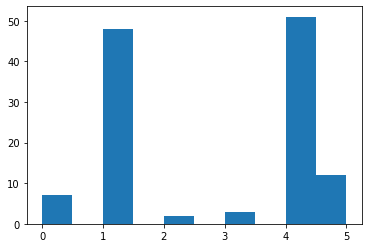

In [35]:
plt.hist(errors_y_)

In [36]:
joint = []
for a, b in zip(errors_y, errors_y_):
    joint.append(f'{a}_{b}')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

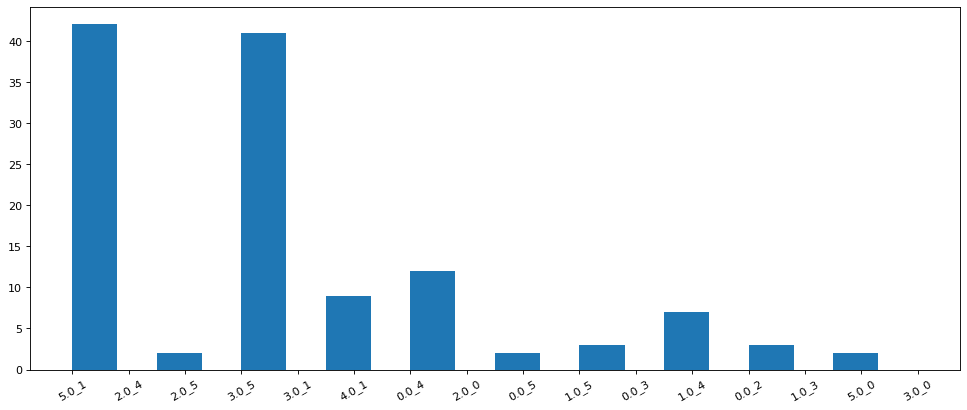

In [46]:
from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=80)
plt.hist(joint, width=0.8)
plt.xticks(rotation=30)


(array([13.,  0.,  9.,  0., 44.,  0., 42.,  0.,  9.,  6.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

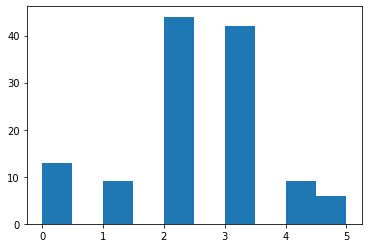

In [34]:
plt.hist(errors_y)

In [31]:
for a, b in zip(errors_y, errors_y_):
    print(a, b)

5.0 1
2.0 4
2.0 5
3.0 5
3.0 1
2.0 4
2.0 4
2.0 4
5.0 1
4.0 1
3.0 1
0.0 4
2.0 0
3.0 1
4.0 1
2.0 0
3.0 1
2.0 0
5.0 1
3.0 1
2.0 4
5.0 1
3.0 1
3.0 1
0.0 5
1.0 5
2.0 4
0.0 3
0.0 4
2.0 4
1.0 4
1.0 4
3.0 1
0.0 3
3.0 1
2.0 4
0.0 2
3.0 1
0.0 4
1.0 3
4.0 1
3.0 1
0.0 4
3.0 1
2.0 4
2.0 4
3.0 5
2.0 4
4.0 1
2.0 4
2.0 4
3.0 1
3.0 1
3.0 1
3.0 1
2.0 4
2.0 0
4.0 1
2.0 4
3.0 5
0.0 4
2.0 4
0.0 4
2.0 4
2.0 4
3.0 1
2.0 4
2.0 4
3.0 1
5.0 0
3.0 1
2.0 4
2.0 4
2.0 4
0.0 5
3.0 1
2.0 4
3.0 1
3.0 1
3.0 1
2.0 4
2.0 4
3.0 5
2.0 4
3.0 1
3.0 1
1.0 4
2.0 5
3.0 5
3.0 1
2.0 0
2.0 4
3.0 0
0.0 4
1.0 4
3.0 1
3.0 5
4.0 1
3.0 1
2.0 4
3.0 1
2.0 4
3.0 1
4.0 1
3.0 5
3.0 1
3.0 1
3.0 1
2.0 4
2.0 4
4.0 1
2.0 4
3.0 1
2.0 4
0.0 2
1.0 4
2.0 4
1.0 4
4.0 1
5.0 1
2.0 4
2.0 4
1.0 4


In [28]:
PATH = './saved_model1115/resFeed1.pth'
torch.save(model.state_dict(), PATH)


In [24]:
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

# Ensure the model is on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []

with torch.no_grad():
    for x_test, y_test, y_test_res in testing_loader1:
        # Move input and target data to the correct device
        x_test = x_test.to(device).float()
        y_test = y_test.to(device).float()
        y_test_res = y_test_res.to(device).float()
        
        # Forward pass
        pred = model(x_test, y_test_res)
        
        # Append predictions and targets to lists
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
        
# Flatten the target list
target_list = np.array(target_list).flatten()

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score


def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)


# Calculate AUC
cutoff = 4
test_target_bi = (target_list >= cutoff).astype(int)
test_predictions_bi = (np.array(pred_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)
Learning rate: 0.0001
Weight decay: 0.0001
Accuracy: 0.5224274406332454
Mae: 0.503957783641161
F1 Score: 0.48083488925470447
conf_matrix: [[ 18  86   8   0   0   0]
 [ 48 330  19   0   0   0]
 [ 15 230  51   0   0   0]
 [  0   0   0 104  44   1]
 [  0   0   0  52  65  20]
 [  0   0   0   6  14  26]]
Doubling Dilution Accuracy: 0.9736147757255936
AUC: 0.8179451489844314
Sensitivity: 0.6830601092896175
Specificity: 0.9528301886792453


## Hypterparameter tuning

In [ ]:
#input parameter
for _ in [1e-4, 5e-4,1e-3, 5e-3,1e-2]:
    lr = 1e-4
    epoch = 400
    conv_dropout_rate=0.4
    dense_dropout_rate=0.7
    weight_decay= _ #1e-4
    ######################################

    model = Model(
    num_classes=6,
    num_filters=64,
    num_conv_layers=2,
    # num_dense_neurons=256, # batch_size = 64
    num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=False,
    conv_dropout_rate=conv_dropout_rate,
    dense_dropout_rate=dense_dropout_rate
    ).to(device)

    # model = Model( #! way too memory intensive
    # num_classes=13,
    # num_filters=128,
    # num_conv_layers=2,
    # num_dense_neurons=64, # batch_size = 64

    # num_dense_layers=2,
    # return_logits=True,
    # conv_dropout_rate=0,
    # dense_dropout_rate=0
    # ).to(device)
    ## early stopping
    best_val_loss = float('inf')
    patience = 8  # How many epochs to wait after last time validation loss improved.
    patience_counter = 0
    lmbda = torch.tensor(1e-4, dtype = torch.float32)

    batch_size = 64
    # lr = 0.0085
    # lr = 0.00002
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

    # train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
    # test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
    # criterion = nn.MSELoss()
    # criterion = masked_weighted_MAE
    # criterion = masked_weighted_MSE
    criterion = weighted_cross_entropy_loss_fn
    # criterion = masked_MAE

    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
    # scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
    #%%

    torch.cuda.empty_cache()
    import gc; gc.collect()
    # ic.enable()
    ic.disable()

    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        # print(f'Epoch {e}')
        for x_train, y_train, y_train_res in train_loader:
            x_batch = torch.squeeze(x_train, 0).to(device)
            y_batch = y_train.to(device)
            y_batch_res = y_train_res.to(device)
            
            x_batch = x_batch.float()
            pred = model(x_batch.float(),y_batch_res.float())

            # break
            # loss_train = loss_corn(pred, y_batch, 3, class_weights)
            # print(pred, y_batch)
            loss_train = criterion(pred,y_batch)
            # print(pred)
            # print(y_batch)
            # print(loss_train)
            train_batch_loss.append(loss_train)        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # scheduler.step()  # Update the learning rate
            # break
        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        model.eval()
        with torch.no_grad():
            # print('>> test')
            for x_test, y_test, y_test_res in test_loader:
                x_batch = torch.squeeze(x_test, 0).to(device)
                x_batch = x_batch.float()
                y_batch = y_test.to(device)
                y_batch_res = y_test_res.to(device)
                # print(x_batch.size())
                # y_batch = torch.Tensor.float(y).to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
                pred = model(x_batch.float(), y_batch_res.float())
                loss_test = criterion(pred,y_batch)
                # pred = pred.unsqueeze(0)
                # print(pred[:10])
                # print(y_batch[:10])

                # loss_test = loss_corn(pred, y_batch, 3, class_weights)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
        if e%50 == 0:
            print(f'Epoch {e}')
            print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
            print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
        # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
        # print(train_batch_loss)
        # print(test_batch_loss)
        # print(f"Training loss: {np.mean(train_batch_loss)}")
        # print(f"Validation loss: {np.mean(test_batch_loss)}")
        # #! implementing early stopping
        # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
        # print(f'Current val loss: {current_val_loss}')
        # print(f'Best val loss: {best_val_loss}')
        # if current_val_loss < best_val_loss:
        #     best_val_loss = current_val_loss
        #     patience_counter = 0  # reset patience counter
        #     # Save the best model
        #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

        # else:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         print("Early stopping triggered")
        #         torch.save({
        #         'optimizer': optimizer.state_dict(),
        #         'model': model.state_dict(),
        #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
        #         break  # Early stopping
            
    print('==='*10)
    # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
    save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
                train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

    fig, ax = plt.subplots()
    x = np.arange(1, epoch+1, 1)
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
    print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

    #%%
    # testing_dataset = Dataset(test_data, test_target, 'EMB_MIC_x','EMB_MIC_y',one_hot_dtype=torch.float, transform=False)
    testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

    # Ensure the model is on the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    ic.disable()
    model.eval()
    pred_list = []
    target_list  = []
    mse_list = []

    with torch.no_grad():
        for x_test, y_test, y_test_res in testing_loader1:
            # Move input and target data to the correct device
            x_test = x_test.to(device).float()
            y_test = y_test.to(device).float()
            y_test_res = y_test_res.to(device).float()
            
            # Forward pass
            pred = model(x_test, y_test_res)
            
            # Append predictions and targets to lists
            pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
            target_list.append(y_test.detach().cpu().numpy())
            
    # Flatten the target list
    target_list = np.array(target_list).flatten()

    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error
    from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score


    def calculate_metrics(true_labels, predictions):
        """
        Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

        Parameters:
        - true_labels: List or array of true labels
        - predictions: List or array of predicted labels

        Returns:
        - accuracy: Overall accuracy of predictions
        - f1: Weighted average F1 score
        - conf_matrix: Multiclass confusion matrix
        - mae: Mean Absolute Error of predictions
        """
        # Ensure inputs are numpy arrays for consistency
        true_labels = np.array(true_labels)
        predictions = np.array(predictions)

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predictions)

        # Calculate F1 score
        f1 = f1_score(true_labels, predictions, average='weighted')

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(true_labels, predictions)

        # Calculate MAE
        mae = mean_absolute_error(true_labels, predictions)

        return accuracy, f1, conf_matrix, mae

    # Example usage
    # true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
    # predictions = [0, 2, 2, 1, 0, 0, 1, 0]

    accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

    print("======================")
    # print("Model's Named Parameters:")
    # for name, param in model.named_parameters():
    #     print(f"Name: {name}")
    #     print(f"Shape: {param.size()}")
    #     print(f"Requires grad: {param.requires_grad}")
    #     print('-----')
    print("Optimizer details:")
    print(optimizer)
    for param_group in optimizer.param_groups:
        print("Learning rate:", param_group['lr'])
        print("Weight decay:", param_group.get('weight_decay', 'Not set'))
        
    print("======================")
    print(f"Accuracy: {accuracy}")
    print(f"Mae: {mae}")
    print(f"F1 Score: {f1}")
    print(f"conf_matrix: {conf_matrix}")
    print("======================")
    doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
    print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)


    # Calculate AUC
    cutoff = 4
    test_target_bi = (target_list >= cutoff).astype(int)
    test_predictions_bi = (np.array(pred_list) >= cutoff).astype(int)

    auc = roc_auc_score(test_target_bi, test_predictions_bi)
    print("AUC:", auc)

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

    # Calculate sensitivity (recall)
    sensitivity = tp / (tp + fn)
    print("Sensitivity:", sensitivity)

    # Calculate specificity
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)

 12%|█▎        | 50/400 [02:56<20:30,  3.52s/it]

Epoch 50
Training loss: 0.1510869264602661
Validation loss: 0.13646160066127777


 25%|██▌       | 100/400 [05:52<17:28,  3.49s/it]

Epoch 100
Training loss: 0.12380748987197876
Validation loss: 0.11622773110866547


 28%|██▊       | 114/400 [06:41<16:51,  3.54s/it]

## One cycle lr

 12%|█▎        | 50/400 [02:28<17:21,  2.97s/it]

Epoch 50
Training loss: 0.11537401378154755
Validation loss: 0.14441072940826416


 25%|██▌       | 100/400 [04:58<14:56,  2.99s/it]

Epoch 100
Training loss: 0.11210744082927704
Validation loss: 0.1536770612001419


 38%|███▊      | 150/400 [07:28<12:28,  3.00s/it]

Epoch 150
Training loss: 0.11056072264909744
Validation loss: 0.16507422924041748


 50%|█████     | 200/400 [09:57<09:53,  2.97s/it]

Epoch 200
Training loss: 0.1097438856959343
Validation loss: 0.17116251587867737


 62%|██████▎   | 250/400 [12:32<07:39,  3.06s/it]

Epoch 250
Training loss: 0.10918270796537399
Validation loss: 0.1748015433549881


 75%|███████▌  | 300/400 [15:02<04:53,  2.94s/it]

Epoch 300
Training loss: 0.10868095606565475
Validation loss: 0.17704497277736664


 88%|████████▊ | 350/400 [17:41<02:47,  3.35s/it]

Epoch 350
Training loss: 0.10827459394931793
Validation loss: 0.18684180080890656


100%|██████████| 400/400 [20:27<00:00,  3.07s/it]

Epoch 400
Training loss: 0.10818441957235336
Validation loss: 0.17728930711746216


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-07_weighted_balanced.png-emb
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.9499999993756804, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0004
    lr: 4.006243171376002e-08
    max_lr: 0.01
    max_momentum: 0.95
    maximize: False
    min_lr: 4e-08
    weight_decay: 0
)
Learning rate: 4.006243171376002e-08
Weight decay: 0
Accuracy: 0.47568523430592397
Mae: 0.6578249336870027
F1 Score: 0.44584107920478183
conf_matrix: [[ 34  66   7   3   1   1]
 [ 63 285  32   9   5   0]
 [ 40 188  41  19   3   2]
 [  4  20   7  75  42   1]
 [  2   8   0  34  77  16]
 [  0   3   0   5  12  26]]
Doubling Dilution Accuracy: 0.8992042440318302


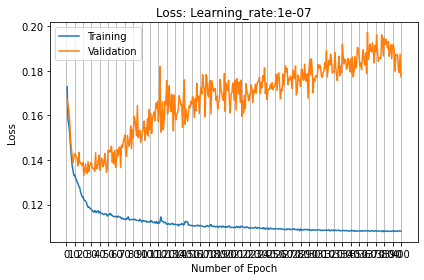

In [22]:
#input parameter
lr = 1e-7
epoch = 400
conv_dropout_rate=0
dense_dropout_rate=0
# weight_decay=1e-8
weight_decay=0


best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr
######################################

model = Model(
num_classes=6,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

criterion = weighted_cross_entropy_loss_fn
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epoch)
# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping




# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
# criterion = weighted_cross_entropy_loss_fn


# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        loss_train = criterion(pred,y_batch)

        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = criterion(pred,y_batch)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    if e % 50 == 0:
        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

## Cyclical lr

In [ ]:
#input parameter
lr = 1e-7
epoch = 250
conv_dropout_rate=0.05
dense_dropout_rate=0.5
weight_decay=1e-8

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-9, max_lr=0.001)
######################################

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
# criterion = weighted_cross_entropy_loss_fn
# criterion = masked_MAE
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        loss_train = criterion(pred,y_batch)

        train_batch_loss.append(loss_train)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())
            loss_test = loss_corn(pred, y_batch, 3, class_weights)

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [19]:
def loss_corn(logits, y_train, num_classes):
    sets = []
    for i in range(num_classes-1):
        label_mask = y_train > i-1
        label_tensor = (y_train[label_mask] > i).to(torch.int64)
        sets.append((label_mask, label_tensor))

    num_examples = 0
    losses = 0.
    for task_index, s in enumerate(sets):
        train_examples = s[0]
        train_labels = s[1]

        if len(train_labels) < 1:
            continue

        num_examples += len(train_labels)
        pred = logits[train_examples, task_index]

        loss = -torch.sum(F.logsigmoid(pred)*train_labels
                          + (F.logsigmoid(pred) - pred)*(1-train_labels)
                          )
        losses += loss
    return losses/num_examples


In [20]:
pred  = torch.tensor([[0.0000, 0.5111],
        [0.1329, 1.1051]], device='cuda:0')
target = torch.tensor([0, 0], device='cuda:0')


In [22]:
out = loss_corn(pred, target, 3)
print(out)

tensor(0.7275, device='cuda:0')


## xgboost with snps and fed in res 

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# def is_within_doubling_dilution(pred, target, target_min, target_max):
#     # Ensure target_min and target_max are scalars
#     target_min = target_min.item() if isinstance(target_min, np.ndarray) or isinstance(target_min, pd.Series) else target_min
#     target_max = target_max.item() if isinstance(target_max, np.ndarray) or isinstance(target_max, pd.Series) else target_max

#     # Create a range based on the scalar values of target_min and target_max
#     dilution_range = np.arange(target_min - 1, target_max + 2, 1)
    
#     # Find the index of the target value
#     index = np.where(dilution_range == target)[0][0]  # Use np.where to find the index
    
#     # Check if prediction is within the acceptable range
#     return dilution_range[index - 1] <= pred <= dilution_range[index + 1]

# Example usage
target_min, target_max = cryptic_drs.min().values, cryptic_drs.max()

# Load the data
cryptic_drs = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_sample_drs_cryptic_emb.npy')
cryptic_snps = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_snps_cryptic_emb.npy')

# Convert to pandas DataFrame
cryptic_drs = pd.DataFrame(cryptic_drs)

# Combine the features and target variable
data = cryptic_snps
target = cryptic_drs

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Create the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = cryptic_drs.min().values, cryptic_drs.max().values

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = 4
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)